### Carga y Preprocesamiento de Datos con Enfoque Socioeconómico y Académico

Esta sección realiza la preparación inicial de los datos incluyendo la selección de variables, limpieza, imputación y carga de librerías necesarias para modelado.

---

#### Librerías

Se importan las librerías necesarias para:

* Manipulación de datos: `pandas`, `numpy`
* Modelado: `RandomForestClassifier`
* Evaluación: `accuracy_score`, `cross_val_score`
* División del dataset: `train_test_split`
* Visualización: `matplotlib.pyplot`

Estas herramientas permiten cargar datos, construir modelos predictivos y visualizar resultados.

---

#### Carga de Datos

Se cargan los archivos `train.csv` y `test.csv`, que contienen información de los estudiantes.

* El dataset `train` incluye la variable objetivo `RENDIMIENTO_GLOBAL`, utilizada para entrenar el modelo.
* El dataset `test` será utilizado para predecir resultados con el modelo entrenado.

Se imprime la forma (número de filas y columnas) de ambos conjuntos como verificación inicial.

---

#### Selección de Variables Socioeconómicas y Académicas

Se seleccionan variables relevantes tanto del contexto **socioeconómico** como **académico** del estudiante, incluyendo:

* Acceso a servicios y educación familiar (`FAMI_*`)
* Costos de matrícula y horas de trabajo (`ESTU_*`)
* Departamento del programa universitario

Estas variables se consideran predictoras clave del rendimiento académico.

---

#### Limpieza de Valores Raros

Se identifican y reemplazan valores considerados inválidos o codificados como desconocidos (`98`, `99`, `999`) por valores nulos (`NaN`).
Esto permite su tratamiento adecuado en la etapa de imputación.

---

#### Imputación Personalizada

Se rellenan los valores faltantes con un valor **específico y representativo** para cada variable.
En lugar de usar la moda o media, se escogen valores comunes o representativos que pueden ayudar al modelo:

* Por ejemplo, `FAMI_ESTRATOVIVIENDA = 'Estrato 2'`, `ESTU_PRGM_DEPARTAMENTO = 'ANTIOQUIA'`.


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Shape train:", train.shape)
print("Shape test :", test.shape)

cols = [
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE',
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'ESTU_HORASSEMANATRABAJA',
    'ESTU_PAGOMATRICULAPROPIO',
    'ESTU_PRGM_DEPARTAMENTO'
]

train = train[['ID'] + cols + ['RENDIMIENTO_GLOBAL']]
test = test[['ID'] + cols]

valores_raros = ['98', '99', '999', 98, 99, 999]
for col in cols:
    train[col] = train[col].replace(valores_raros, np.nan)
    test[col] = test[col].replace(valores_raros, np.nan)

imputacion = {
    'FAMI_ESTRATOVIVIENDA': 'Estrato 2',
    'FAMI_TIENEINTERNET': 'No',
    'FAMI_EDUCACIONPADRE': 'Secundaria (Bachillerato) completa',
    'FAMI_EDUCACIONMADRE': 'Secundaria (Bachillerato) completa',
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Entre 1 millón y menos de 2.5 millones',
    'ESTU_HORASSEMANATRABAJA': 'Entre 11 y 20 horas',
    'ESTU_PAGOMATRICULAPROPIO': 'No',
    'ESTU_PRGM_DEPARTAMENTO': 'ANTIOQUIA'
}

for col, valor in imputacion.items():
    train[col] = train[col].fillna(valor)
    test[col] = test[col].fillna(valor)

Shape train: (692500, 21)
Shape test : (296786, 20)


### Transformación de Datos, Entrenamiento con Random Forest y Análisis de Importancia

En esta parte se transforma el dataset para modelado, se entrena un clasificador Random Forest, se evalúa su rendimiento y se generan predicciones finales. También se analiza la importancia de cada variable.

---

#### One-Hot Encoding y Alineación

Las variables categóricas seleccionadas se convierten en variables numéricas usando **One-Hot Encoding**, una técnica que:

* Crea una nueva columna para cada categoría.
* Asigna un 1 si la instancia pertenece a esa categoría, o un 0 si no.

Luego, se alinean las columnas del conjunto de prueba con las del conjunto de entrenamiento para asegurar compatibilidad con el modelo (rellenando con 0 donde falten categorías).

---

#### Codificación de la Variable Objetivo

La variable `RENDIMIENTO_GLOBAL` se convierte de texto a números enteros utilizando un diccionario de mapeo:

* `bajo` → 0
* `medio-bajo` → 1
* `medio-alto` → 2
* `alto` → 3

Esto facilita el entrenamiento del modelo, que requiere variables numéricas como objetivo (`y`).

---

#### División de Datos

Se divide el conjunto de entrenamiento en:

* **70% para entrenamiento** (`Xtrain`, `ytrain`)
* **30% para validación** (`Xval`, `yval`)

Esto permite evaluar la capacidad del modelo para generalizar a datos nuevos antes de realizar predicciones finales.

---

#### Entrenamiento del Modelo Random Forest

Se entrena un modelo **Random Forest**, que es un conjunto de árboles de decisión que trabajan en conjunto para mejorar la precisión y reducir el sobreajuste.

Parámetros usados:

* `n_estimators=100`: se construyen 100 árboles.
* `max_depth=10`: se limita la profundidad de los árboles para controlar la complejidad.
* `random_state=42`: asegura resultados reproducibles.

---

#### Evaluación del Modelo

El modelo se evalúa usando:

* **Accuracy en la validación**: mide qué tan bien clasifica en el 30% reservado del conjunto `train`.
* **Validación cruzada (CV=5)**: realiza 5 particiones diferentes del dataset para obtener una estimación más robusta del rendimiento general.

Se imprime la media y la desviación estándar de los resultados de la validación cruzada.

---

#### Predicción Final

El modelo se reentrena con **todo el conjunto de entrenamiento** (`X`, `y`) para aprovechar al máximo la información disponible.
Luego, se generan predicciones sobre el conjunto de prueba (`test`).

---

#### Generación del Archivo de Envío (`submission.csv`)

Se crea un archivo `.csv` con las predicciones:

* Se utiliza el `ID` de cada instancia y la categoría original (`bajo`, `medio-bajo`, etc.) correspondiente a cada predicción.
* El archivo `submission.csv` se guarda listo para ser enviado o analizado.

---

#### Análisis de Importancia de Variables

Se extrae la **importancia relativa** de cada variable en el modelo Random Forest.
Esto permite identificar qué características tienen mayor impacto en las predicciones.

Se grafican las 10 variables más importantes, lo cual:

* Ayuda a interpretar el modelo.
* Informa futuras decisiones sobre selección de variables.

Accuracy en validación: 0.3929
CV Accuracy: 0.3918 ± 0.0010
Primeras filas del archivo submission:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185         medio-alto


/var/folders/fd/qgxmkgpj4zl6sp8f4cw4l3840000gn/T/ipykernel_1963/939688887.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.grid(); plt.tight_layout()


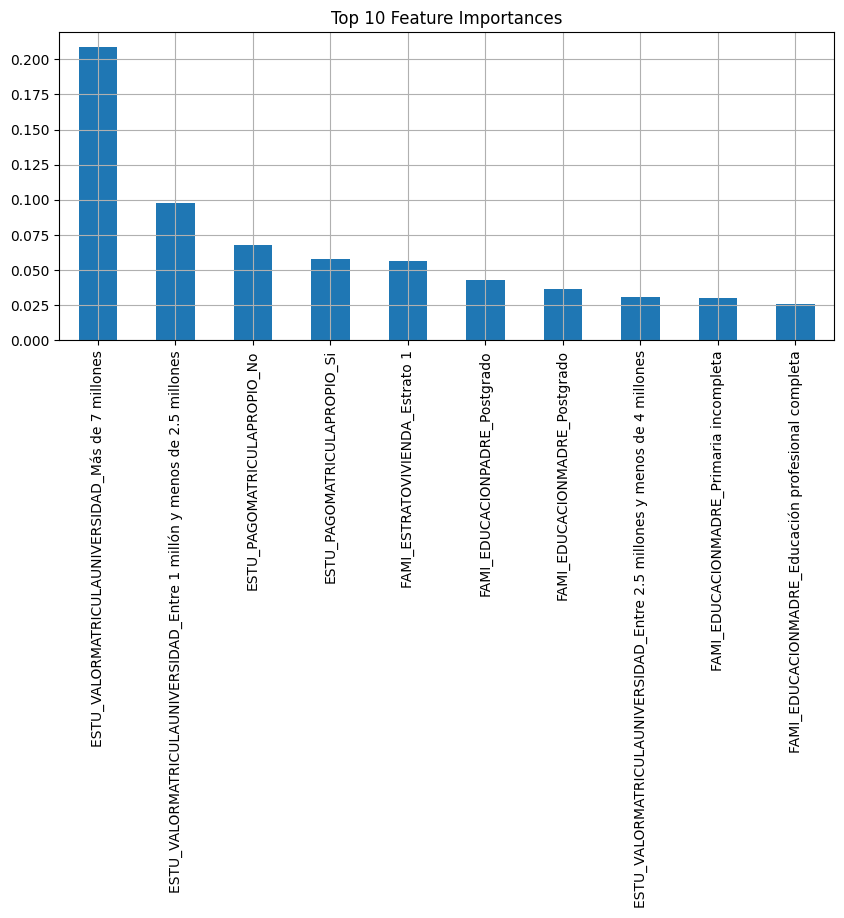

In [3]:
def one_hot(df, col):
    return pd.concat([df.drop(columns=[col]), pd.get_dummies(df[col], prefix=col)], axis=1)

for col in cols:
    train = one_hot(train, col)
    test = one_hot(test, col)

test = test.reindex(columns=train.drop(columns=['RENDIMIENTO_GLOBAL']).columns, fill_value=0)

mapa = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
inv_mapa = {v: k for k, v in mapa.items()}
y = train['RENDIMIENTO_GLOBAL'].map(mapa)
X = train.drop(columns=['RENDIMIENTO_GLOBAL'])

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(Xtrain, ytrain)

yval_pred = clf.predict(Xval)
acc = accuracy_score(yval, yval_pred)
print(f"Accuracy en validación: {acc:.4f}")
scores = cross_val_score(clf, X, y, cv=5)
print(f"CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

clf.fit(X, y)
y_pred = clf.predict(test)

submission = pd.DataFrame({
    'ID': test['ID'],
    'RENDIMIENTO_GLOBAL': pd.Series(y_pred).map(inv_mapa)
})

submission.to_csv("submission.csv", index=False)
print("Primeras filas del archivo submission:")
print(submission.head())

importances = clf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

top_n = 10
feat_imp.head(top_n).plot(kind='bar', figsize=(10, 4), title=f"Top {top_n} Feature Importances")
plt.grid(); plt.tight_layout()